In [223]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [224]:
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Admissions Predictors

In [225]:
aux = pd.read_csv('data.csv',  index_col=0, parse_dates=[0])
df = pd.DataFrame(aux['occupancy'])

df = df.tail(int(0.8*len(df)))

## The Real Deal

In [226]:
def decomp(df, p):
    df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
    df['r_occupancy'] = df['occupancy']-df['s_occupancy']
    aux_df = df.dropna()
    return df, aux_df

In [227]:
def xy_matrices(df, key,q, l, transform = False):  
    predictors_dict = {}
    for i in range(len(df)-(q+l-1)):
        predictors_dict[i] = df[key].iloc[i:i+q+l].values #the 1 is actually l
        
    predictors = pd.DataFrame(predictors_dict).T 
    
    if transform :
        predictors = transform(predictors) 
    
    y = predictors[np.arange(q, q+l, 1)].values #here I need l dependence 
    x_predictors = predictors.drop(np.arange(q, q+l, 1), axis=1).values #here too
    
    return x_predictors, y

In [228]:
def transform(df): #acts on dataframes, scaler is global function/variable
    X = df.values
    X = scaler.fit_transform(X)
    return pd.DataFrame(X)

In [229]:
def inverse_transform(X, y): #acts on arrays, scaler is global function/variable
    aux = np.column_stack((X,y)) 
    aux = scaler.inverse_transform(aux)
    return aux[:,-1]

In [230]:
def chrono_split(X,y, f):
    l = len(y)
    X_train = X[0:int(f*l)]
    X_test = X[int(f*l):]
    y_train = y[0:int(f*l)]
    y_test = y[int(f*l):]
    return X_train, X_test, y_train, y_test

In [231]:
def max_error(y_test, y_forecast):
    return  np.max(np.abs(y_test-y_forecast))
def abs_error(y_test, y_forecast):
    return np.mean(np.abs(y_test-y_forecast))
def rsm_error(y_test, y_forecast):
    return np.sqrt(np.sum((y_test-y_forecast)**2))/np.sqrt(len(y_test))

In [232]:
model_linear = linear_model.LinearRegression()
model_nene = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-9,
                    hidden_layer_sizes=(350, 350), random_state=0,
                    max_iter=2000,  warm_start=True)
model_tree = tree.DecisionTreeRegressor()
model_gbr = GradientBoostingRegressor(n_estimators=750, learning_rate=0.1,
                                      max_depth=1, random_state=0, loss='ls',
                                      warm_start=True)
model_svr = svm.SVR(gamma='auto')

scaler = StandardScaler()

In [233]:
models = {'linear':model_linear ,'nene': model_nene}
errors = {'max':max_error ,'abs': abs_error, 'rsm':rsm_error}

## Linear Model

In [234]:
l = 7#forecast
q = 35 #lagging

f = 0.70
X, y = xy_matrices(df,'occupancy' ,q, l, False)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [235]:
trials = {}
ntrials = 400

In [236]:
for i in range(0,ntrials):
    mask = np.random.binomial(1,0.8, X_train.shape[0])
    training = X_train[mask == 1]
    target = y_train[mask == 1]
    
    trials[i] =  models['linear'].fit(training, target)

In [237]:
walks = {}
for i in range(0,ntrials):
    walks[i] = trials[i].predict(X_test)

In [238]:
prior = df.head(X_train.shape[0]).values
aux_1 = np.append(prior, y_test[0,:])

l_aux = int(0.95*len(aux_1))
y_aux = np.linspace(1, len(aux_1), len(aux_1))

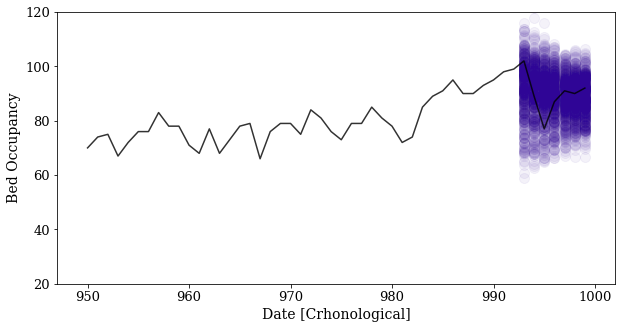

In [239]:
cmap = cm.plasma
colors = np.linspace(0,0.95, ntrials)

plt.figure(figsize=(10,5))
plt.plot(y_aux[l_aux:], aux_1[l_aux:], color='black', alpha = 0.80)

for i in range(0, ntrials):
    aux_2 = np.append(np.zeros(len(prior)), walks[1][i,:])
    plt.scatter(y_aux[l_aux:], aux_2[l_aux:], color = cmap(colors[25]) , alpha = 0.05, s = 100)

plt.ylim([20,120])
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.ylabel('Bed Occupancy', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig('linear_forecast.png', bbox='tight')
plt.show()

## Random Walk

In [240]:
l = 1#forecast
q = 35 #lagging

f = 0.70
X, y = xy_matrices(df,'occupancy' ,q, l, False)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [241]:
p = 30
df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
df['r_occupancy'] = df['occupancy']-df['s_occupancy']
df = df.dropna()

In [242]:
X_r, y_r = xy_matrices(df,'r_occupancy' ,q, l, False)
X_train_r, X_test_r, y_train_r, y_test_r = chrono_split(X_r, y_r, f)

sigma = np.std(y_train_r)

In [243]:
for model in models:
    models[model].fit(X_train, y_train)

/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [244]:
ntrials = 500

In [245]:
prob_dist = {}

for trial in range(ntrials):
    step = X_test[-1,:]
    random_walk = np.array([])
    for day in range(0,X_test.shape[0]):
        dy = np.random.normal(loc=0, scale = sigma)
        y_rw = models['nene'].predict(step.reshape(1,-1))[0]
        step = np.append(step[1:], y_rw) + 0.05*dy
        random_walk = np.append(random_walk, y_rw)

    prob_dist[trial] = random_walk

In [246]:
prior = df['occupancy'].head(X_train.shape[0]).values
aux_1 = np.append(prior, y_test)
y_aux = np.linspace(1, len(aux_1), len(aux_1))

l_aux = int(0.95*len(aux_1))

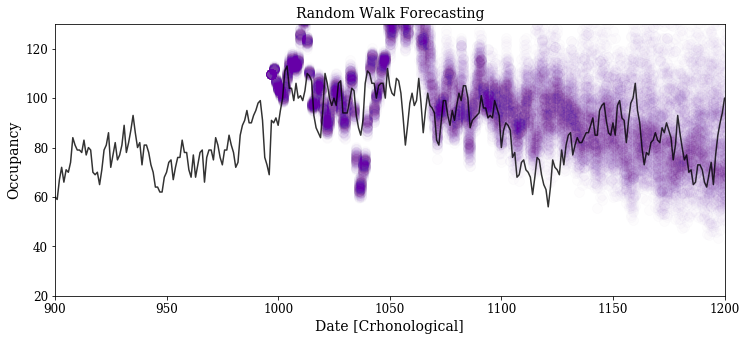

In [247]:
cmap = cm.plasma
colors = np.linspace(0,0.75, 100)

plt.figure(figsize=(12,5))
for trial in range(100):
    aux_2 = np.append(np.zeros(len(prior)), prob_dist[trial])
    plt.scatter(y_aux, aux_2, color=cmap(colors[25]), alpha = 0.01, s=100)
    #plt.plot(prob_dist[trial], color = cmap(colors[25]), alpha = 0.05)
    #plt.plot(y_test, color='k', lw=1)
plt.plot(y_aux, aux_1, color='black', alpha = 0.80)



plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best', fontsize=12)
plt.title('Random Walk Forecasting', fontsize = 14)
plt.ylim([20,130])
plt.xlim([900,1200])

plt.savefig('rw_forecast.png', bbox='tight')
plt.show()

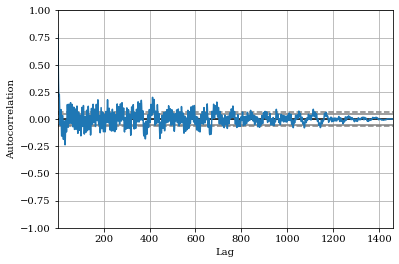

In [248]:
pd.plotting.autocorrelation_plot(df['r_occupancy'])

In [249]:
lag = np.linspace(0,60, 61, dtype=int)

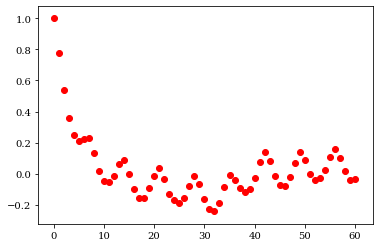

In [250]:
for l in lag:
    ac = df['r_occupancy'].autocorr(lag = l)
    plt.scatter(l, ac, color='red')
plt.show()